In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

import wrangle as w
import scipy.stats as stats

In [2]:
mental_health_df, population_df, rates_df, depressive_rates_df = w.separate_data()

mental_health_df = w.clean_mental_health_data(mental_health_df)
depressive_rates_df = w.clean_depressive_rates_data(depressive_rates_df)
population_df = w.clean_population_data(population_df)
rates_df = w.clean_rates_data(rates_df)

yearly_disorders, yearly_prevalence_sex, yearly_depressive_rates, yearly_suicide_rates = w.yearly_aggregation()

df = w.merge_yearly_aggregation()

train_yearly, test_yearly = w.split_yearly_data()

train, validate, test = w.split_data(df)

There are 0, 0.0%, null values in index
There are 0, 0.0%, null values in entity
There are 980, 15.15%, null values in code
There are 0, 0.0%, null values in year
There are 0, 0.0%, null values in schizophrenia
There are 0, 0.0%, null values in bipolar_disorder
There are 0, 0.0%, null values in eating_disorders
There are 0, 0.0%, null values in anxiety_disorders
There are 0, 0.0%, null values in drug_use_disorders
There are 0, 0.0%, null values in depression
There are 0, 0.0%, null values in alcohol_use_disorders
There are 0, 0.0%, null values in index
There are 0, 0.0%, null values in entity
There are 1726, 3.61%, null values in code
There are 0, 0.0%, null values in year
There are 41339, 86.47%, null values in schizophrenia
There are 41339, 86.47%, null values in bipolar_disorder
There are 924, 1.93%, null values in eating_disorders
There are 47807, 100.0%, null values in anxiety_disorders
There are 47807, 100.0%, null values in drug_use_disorders
There are 47807, 100.0%, null values

### Questions to explore 

    1. Is there a difference in the rate of depression in the United States versus the rest of the world?
    2. Are the rates of any of the mental health disorders decreasing? What is the rate for each disorder from 1990 to 2017?
    3. Is there a difference in the rates of the happiest country vs the least happy country?
    4. Is there a difference in rates of depression between two populations: 1) Iceland, Portugal, Canada, Australia and Sweden and 2) the rest of the world?

**Question 1:**  Is there a difference in the rate of depression in the United States versus the rest of the world?

To test this question, I will conduct a means comparison hypothesis test using the rates_df dataset.

In [3]:
us_rates_df = rates_df[rates_df.entity == 'United States']
world_rates_df = rates_df[rates_df.entity != 'United States']

<AxesSubplot:>

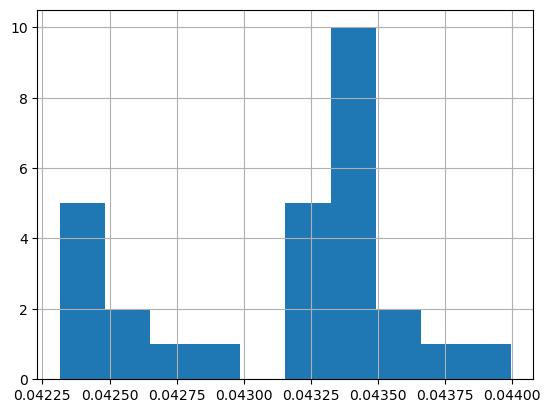

In [4]:
us_rates_df.percentage_depressive_disorder.hist()

<AxesSubplot:>

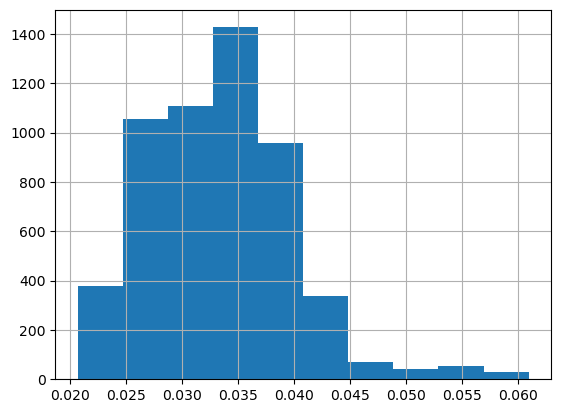

In [5]:
world_rates_df.percentage_depressive_disorder.hist()

H$_O$: There is no difference in the means of rates of depression between the world and the US.

H$_A$: There is difference in the means of rates of depression between the world and the US.

In [6]:
us = us_rates_df.percentage_depressive_disorder
world = world_rates_df.percentage_depressive_disorder.mean()

t_stat, p = stats.ttest_1samp(us, world)
α = 0.05
if p < α:
    print('We must reject the null hypothesis and conclude with some confidence that the means are different.')

We must reject the null hypothesis and conclude with some confidence that the means are different.


Now that we know the two are different, let's see if the US mean is greater than the world's mean.

H$_O$: The mean rate of depression for the US is less than or equal to that of the rest of the world.

H$_A$: The mean rate of depression for the US is greater than that of the rest of the world.

In [7]:
if ((p / 2) < α) and (t_stat > 0):
    print('We must reject the null hypothesis and conclude that the mean for the US is greater than or equal to that of the rest of the world.')

We must reject the null hypothesis and conclude that the mean for the US is greater than or equal to that of the rest of the world.


In [103]:
us.mean()

0.0431372269132143

In [105]:
world.mean()

0.03333298060027293

Takeaway: The rates of depression in the US are greater than those globally. 

**Question 2:**  Are the rates of any of the mental health disorders decreasing? What is the rate for each disorder from 1990 to 2017?

To explore this set of questions, I will use the mental_health_df

In [8]:
diff_df = mental_health_df.copy()
for col in diff_df.columns:
    if col != 'entity' and col != 'code':
        diff_df[f'last_year_diff_{col}'] = diff_df[col] - diff_df[col].shift(1)

In [9]:
diff_df

,entity,code,schizophrenia,bipolar_disorder,eating_disorders,anxiety_disorders,drug_use_disorders,depression,alcohol_use_disorders,last_year_diff_schizophrenia,last_year_diff_bipolar_disorder,last_year_diff_eating_disorders,last_year_diff_anxiety_disorders,last_year_diff_drug_use_disorders,last_year_diff_depression,last_year_diff_alcohol_use_disorders
year,,,,,,,,,,,,,,,,
1990,Afghanistan,AFG,0.160560,0.697779,0.101855,4.828830,1.677082,4.071831,0.672404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,Afghanistan,AFG,0.160312,0.697961,0.099313,4.829740,1.684746,4.079531,0.671768,-0.000248,0.000182,-0.002542,0.000910,0.007664,0.007700,-0.000636
1992,Afghanistan,AFG,0.160135,0.698107,0.096692,4.831108,1.694334,4.088358,0.670644,-0.000177,0.000146,-0.002621,0.001368,0.009588,0.008827,-0.001124
1993,Afghanistan,AFG,0.160037,0.698257,0.094336,4.830864,1.705320,4.096190,0.669738,-0.000098,0.000150,-0.002356,-0.000244,0.010986,0.007832,-0.000906
1994,Afghanistan,AFG,0.160022,0.698469,0.092439,4.829423,1.716069,4.099582,0.669260,-0.000015,0.000212,-0.001897,-0.001441,0.010749,0.003392,-0.000478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,Zimbabwe,ZWE,0.155670,0.607993,0.117248,3.090168,0.766280,3.128192,1.515641,0.000205,0.000498,0.000459,0.002958,0.002441,0.010120,0.000148
2014,Zimbabwe,ZWE,0.155993,0.608610,0.118073,3.093964,0.768914,3.140290,1.515470,0.000323,0.000617,0.000825,0.003796,0.002634,0.012098,-0.000171
2015,Zimbabwe,ZWE,0.156465,0.609363,0.119470,3.098687,0.771802,3.155710,1.514751,0.000472,0.000753,0.001397,0.004723,0.002888,0.015420,-0.000719


In [10]:
diff_df.columns

Index(['entity', 'code', 'schizophrenia', 'bipolar_disorder',
       'eating_disorders', 'anxiety_disorders', 'drug_use_disorders',
       'depression', 'alcohol_use_disorders', 'last_year_diff_schizophrenia',
       'last_year_diff_bipolar_disorder', 'last_year_diff_eating_disorders',
       'last_year_diff_anxiety_disorders', 'last_year_diff_drug_use_disorders',
       'last_year_diff_depression', 'last_year_diff_alcohol_use_disorders'],
      dtype='object')

In [11]:
diff_df.drop(columns={'schizophrenia', 'bipolar_disorder',
       'eating_disorders', 'anxiety_disorders', 'drug_use_disorders',
       'depression', 'alcohol_use_disorders'}, inplace=True)
diff_df = diff_df.groupby('year').mean()

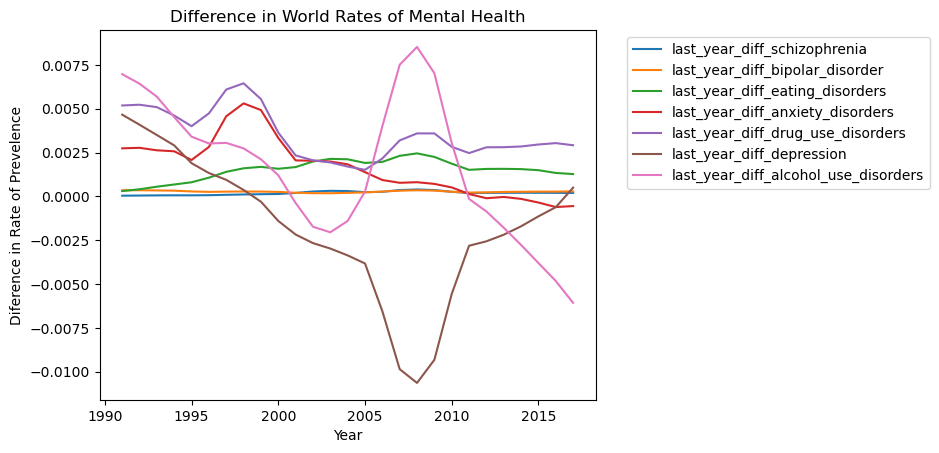

In [12]:
for col in diff_df.columns:
    if col != 'entity' and col != 'code':
        diff_df[col][1:].plot()
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        plt.title('Difference in World Rates of Mental Health')
        plt.xlabel('Year')
        plt.ylabel('Diference in Rate of Prevelence')

In [14]:
yearly_disorders, yearly_prevalence_sex, yearly_depressive_rates, yearly_suicide_rates = w.yearly_aggregation()

There are 0, 0.0%, null values in index
There are 0, 0.0%, null values in entity
There are 980, 15.15%, null values in code
There are 0, 0.0%, null values in year
There are 0, 0.0%, null values in schizophrenia
There are 0, 0.0%, null values in bipolar_disorder
There are 0, 0.0%, null values in eating_disorders
There are 0, 0.0%, null values in anxiety_disorders
There are 0, 0.0%, null values in drug_use_disorders
There are 0, 0.0%, null values in depression
There are 0, 0.0%, null values in alcohol_use_disorders
There are 0, 0.0%, null values in index
There are 0, 0.0%, null values in entity
There are 1726, 3.61%, null values in code
There are 0, 0.0%, null values in year
There are 41339, 86.47%, null values in schizophrenia
There are 41339, 86.47%, null values in bipolar_disorder
There are 924, 1.93%, null values in eating_disorders
There are 47807, 100.0%, null values in anxiety_disorders
There are 47807, 100.0%, null values in drug_use_disorders
There are 47807, 100.0%, null values

In [45]:
changes_disorders = pd.concat([yearly_disorders.head(1), yearly_disorders.tail(1)])
changes_disorders = changes_disorders.T

In [52]:
changes_disorders[f'change_over_time'] = changes_disorders[2017] - changes_disorders[1990]

In [53]:
changes_disorders

year,1990,2017,change_over_time
schizophrenia,0.209548,0.214705,0.005157
bipolar_disorder,0.715392,0.722693,0.007301
eating_disorders,0.221774,0.262806,0.041032
anxiety_disorders,3.957269,4.002347,0.045078
drug_use_disorders,0.808283,0.903575,0.095292
depression,3.506288,3.456795,-0.049493
alcohol_use_disorders,1.546533,1.590201,0.043668


In [62]:
change_in_rates = rates_df.copy()
change_in_rates = change_in_rates.groupby('year').mean()
change_in_rates = pd.concat([change_in_rates.head(1), change_in_rates.tail(1)])
change_in_rates = change_in_rates.T
change_in_rates['change_over_time'] = change_in_rates[2017] - change_in_rates[1990]
change_in_rates

year,1990,2017,change_over_time
population,5.431311e+07,7.695605e+07,2.264293e+07
percentage_suicide,1.268699e-04,1.026680e-04,-2.420183e-05
percentage_depressive_disorder,3.359131e-02,3.278426e-02,-8.070437e-04
num_suicide,8.269010e+03,7.685582e+03,-5.834286e+02
num_depressed,1.879130e+06,2.566030e+06,6.869000e+05


Takeaway: All mental health disorders other than depression have been increasing in the world's population from 1990 to 2017. The rates_df confirms that the percent of population effected by suicide and depression has indeed decreased, though the raw number of people with depression has increased. This may be due to the increase in the global population during this time period. 

**Question 3:**  Is there a difference in the rates of the happiest country vs the least happy country?

According to the World Happiness Report, in 2017 the happiest country in the world was Norway, and the least happy country was Afghanistan.

Sources: https://worldhappiness.report/ed/2017/#:~:text=Norway%20tops%20the%20global%20happiness,in%20a%20tightly%20packed%20bunch.

To answer this question, I will conduct a two sample means comparison hypothesis test.

In [68]:
afghanistan = rates_df[rates_df.entity == 'Afghanistan'].percentage_depressive_disorder
norway = rates_df[rates_df.entity == 'Norway'].percentage_depressive_disorder

<AxesSubplot:>

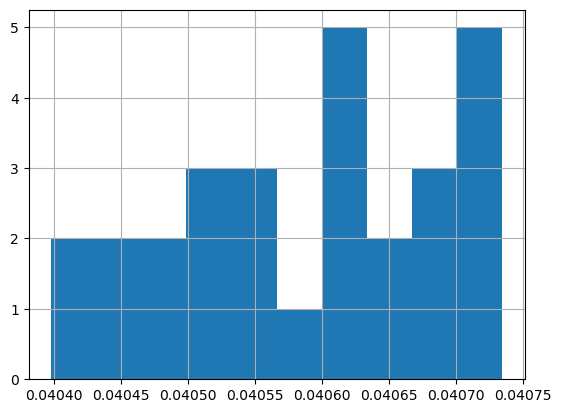

In [69]:
afghanistan.hist()

<AxesSubplot:>

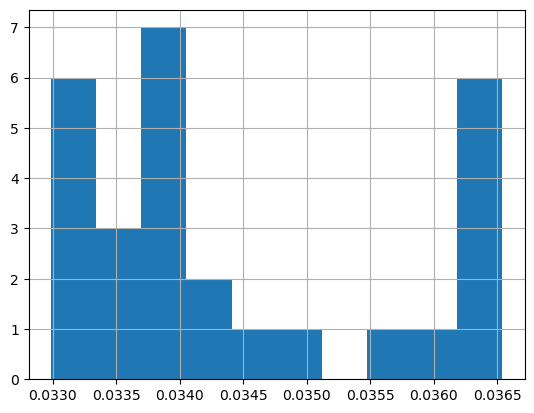

In [70]:
norway.hist()

H$_O$: Afghanistan's percentage depressive disorder and Norway's percentage depressive disorder have equal variance.

H$_A$: Afghanistan's percentage depressive disorder and Norway's percentage depressive disorder have inequal variance.

In [74]:
α = 0.05

t_stat, p = stats.levene(afghanistan, norway)

if p < α:
    print('We must reject the null hypothesis and conclude with some confidence that the two countires\' depression rates have inequal variance.')

We must reject the null hypothesis and conclude with some confidence that the two countires' depression rates have inequal variance.


H$_O$: Afghanistan's mean percentage depressive disorder and Norway's mean percentage depressive disorder do not differ significantly. 

H$_A$: Afghanistan's mean percentage depressive disorder and Norway's mean percentage depressive disorder  differ significantly. 

In [78]:
t_stat, p = stats.ttest_ind(afghanistan, norway, equal_var=False)

if p < α:
    print('We must reject the null hypothesis, and conclude with some confidence that the  two means differ.')

We must reject the null hypothesis, and conclude with some confidence that the  two means differ.


In [101]:
afghanistan.mean()

0.04058931397607143

In [102]:
norway.mean()

0.03444661927928571

Takeaway:  This test affirms that the data in fact supports that Norway was the happiest country and that Afghanistan was the least happy country in 2017 based on the depressive disorder percentages.

**Question 4:**  Is there a difference in rates of depression between two populations: 1) Iceland, Portugal, Canada, Australia and Sweden and 2) the rest of the world?

In [91]:
happy_countries = rates_df[(rates_df.entity == 'Iceland') | (rates_df.entity == 'Portugal') | (rates_df.entity == 'Canada') | (rates_df.entity == 'Australia') | (rates_df.entity == 'Sweden')].percentage_depressive_disorder

In [92]:
world = rates_df[~(rates_df.entity == 'Iceland') | (rates_df.entity == 'Portugal') | (rates_df.entity == 'Canada') | (rates_df.entity == 'Australia') | (rates_df.entity == 'Sweden')].percentage_depressive_disorder

<AxesSubplot:>

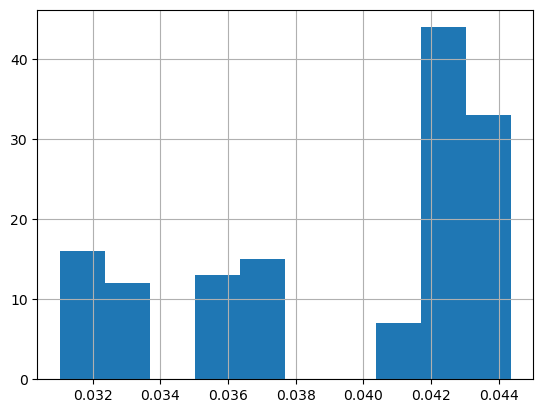

In [94]:
happy_countries.hist()

<AxesSubplot:>

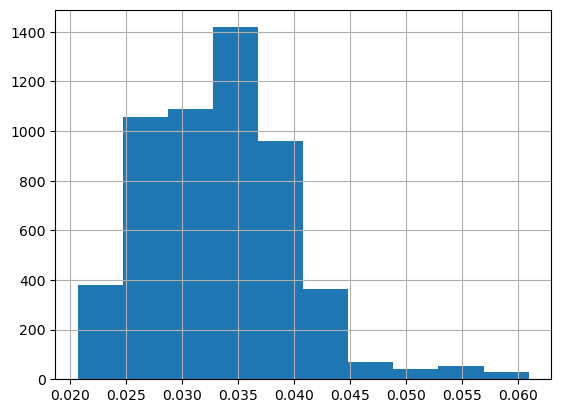

In [95]:
world.hist()

H 𝑂 : There is no difference in the means of rates of depression between the world and the top 5 happiest countries.

H 𝐴 : There is difference in the means of rates of depression between the world and the top 5 happiest countries.

In [96]:
t_stat, p = stats.ttest_1samp(happy_countries, world.mean())
α = 0.05
if p < α:
    print('We must reject the null hypothesis and conclude with some confidence that the means are different.')

We must reject the null hypothesis and conclude with some confidence that the means are different.


H 𝑂 : The mean rate of depression in the top 5 happiest coutries is less than or equal to that of the rest of the world.

H 𝐴 : The mean rate of depression of the top 5 happiest countries is greater than that of the rest of the world.

In [97]:
if ((p / 2) < α) and (t_stat > 0):
    print('We must reject the null hypothesis and conclude that the mean for the top 5 happiest countries is greater than that of the rest of the world.')

We must reject the null hypothesis and conclude that the mean for the top 5 happiest countries is greater than that of the rest of the world.


Takeaways:  Contrary to what we may have predicted, we see that the data does show that the happiest countries in the world have a greater percentage of the population effected by depressive disorders.

**Bonus Question:** Conduct a hypothesis test on females vs males with deressive disorders.